In [6]:
from domgen.models import get_model
from domgen.data import PACS
from domgen.eval import get_features_with_reduction, visualize_features_by_block, reduce_features_by_block
import torch

mod_path = '../experiments/densenet121-pt-mixstyle-pacs/checkpoints/best.pth'


data = PACS('../datasets/', test_domain=1, subset=0.1)
train, val, test = data.generate_loaders(batch_size=32)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
checkpoint = torch.load(mod_path, map_location='cuda', weights_only=True)
mod = get_model(model_name='DenseNet121', num_classes=7, pretrained=False)
mod.load_state_dict(checkpoint["model_state_dict"], strict=False)
model = mod.to(device)

In [11]:
from matplotlib import pyplot as plt
import torch
import torch.nn.functional as F
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def get_densenet_final_layers(model):
    """
    Retrieves the final layers of DenseBlocks from a DenseNet model.

    :param model: DenseNet model.
    :return: List of final layers in each DenseBlock.
    """
    final_layers = []
    for name, module in model.features.named_children():
        if "DenseBlock" in name:
            # Navigate into the DenseBlock and get the last layer of its 'block'
            final_layers.append(list(module.block.children())[-1])
    return final_layers

def register_densenet_hooks(final_layers, features, reduction):
    """
    Registers forward hooks on final layers of DenseBlocks to extract features.

    :param final_layers: List of final layers in each DenseBlock.
    :param features: Dictionary to store extracted features.
    :param reduction: Feature reduction method ('avg_pool' or 'flatten').
    :return: List of hooks.
    """
    hooks = []

    def get_hook(block_name):
        def hook(module, input, output):
            if reduction == 'avg_pool':
                pooled = F.adaptive_avg_pool2d(output, (1, 1)).squeeze(-1).squeeze(-1)
            elif reduction == 'flatten':
                pooled = output.view(output.size(0), -1)
            else:
                raise ValueError("Invalid reduction method. Use 'avg_pool' or 'flatten'.")
            features[block_name].append(pooled.detach().cpu())
        return hook

    for i, layer in enumerate(final_layers):
        block_name = f'block_{i+1}'
        hooks.append(layer.register_forward_hook(get_hook(block_name)))
    return hooks

def get_densenet_features_with_reduction(
        model,
        dataloader,
        device,
        reduction='avg_pool',
        n_components=2
):
    """
    Extracts and reduces features from final layers of DenseBlocks in a DenseNet model.

    :param model: DenseNet model.
    :param dataloader: DataLoader for input data.
    :param device: Device to run the model on.
    :param reduction: Feature reduction method ('avg_pool' or 'flatten').
    :param n_components: Number of dimensions to reduce to (for 'flatten' features).
    :return: Reduced features and labels.
    """
    model.eval()
    features = {f'block_{i+1}': [] for i in range(len(get_densenet_final_layers(model)))}
    labels = []

    final_layers = get_densenet_final_layers(model)
    hooks = register_densenet_hooks(final_layers, features, reduction)

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs['image'].to(device)
            _ = model(inputs)
            labels.append(targets)

    for hook in hooks:
        hook.remove()

    reduced_features = {}
    for block, feats in features.items():
        feats = torch.cat(feats, dim=0).numpy()
        if reduction == 'flatten' and n_components is not None:
            reducer = PCA(n_components=n_components) if n_components > 2 else TSNE(n_components=n_components)
            feats = reducer.fit_transform(feats)
        reduced_features[block] = feats

    labels = torch.cat(labels, dim=0).numpy()
    return reduced_features, labels

def visualize_features_by_block(
        reduced_features,
        labels,
        savepath: str = '.',
        show: bool = False,
):
    """
    Visualizes reduced features from each block in a grid of subplots.

    :param reduced_features: Dictionary of reduced features from each block.
    :param labels: Corresponding labels for coloring.
    """
    num_blocks = len(reduced_features)
    fig, axes = plt.subplots(1, num_blocks, figsize=(5 * num_blocks, 5))

    for i, (block_name, features) in enumerate(reduced_features.items()):
        ax = axes[i] if num_blocks > 1 else axes
        scatter = ax.scatter(features[:, 0], features[:, 1], c=labels, cmap='tab10', alpha=0.7)
        ax.set_title(f'{block_name} Features')
        ax.set_xlabel('Dimension 1')
        ax.set_ylabel('Dimension 2')
        ax.grid(True)

    plt.colorbar(scatter, ax=axes, label='Class Label', orientation='horizontal', pad=0.1)
    plt.savefig(f'{savepath}/latentspace.png', dpi=300)
    if show:
        plt.show()



In [12]:
block_features, labels = get_densenet_features_with_reduction(model, train, device, reduction='flatten')

4
Getting final layers
4
Getting hooks
Sending data through model
Removing hooks
Reducing features
Reducing features for block
Reducing features for block
Reducing features for block
Reducing features for block


In [14]:
reduced_block_features = reduce_features_by_block(block_features, method='tsne', n_components=2)

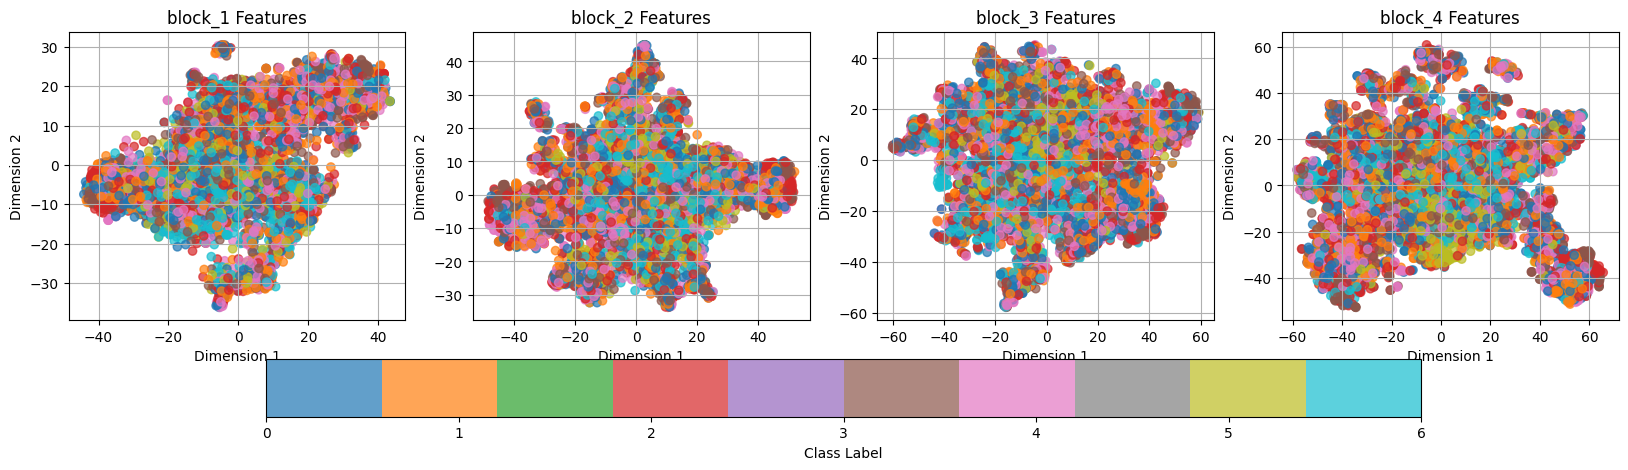

In [17]:
visualize_features_by_block(block_features, labels)

In [ ]:
def get_features_with_reduction(
        model,
        dataloader,
        device,
        reduction='avg_pool',
        n_components=2,
):
    model.eval()
    features = {f'block_{i+1}': [] for i in range(4)}
    labels = []

    layer_names = ['layer1', 'layer2', 'layer3', 'layer4']
    last_layers = [list(getattr(model, name).children())[-1] for name in layer_names]

    def get_hook(block_name):
        def hook(module, input,output):
            if reduction == 'avg_pool':
                pooled = F.adaptive_avg_pool2d(output, (1, 1)).squeeze(-1).squeeze(-1)
            elif reduction == 'flatten':
                pooled = output.view(output.size(0), -1)
            else:
                raise ValueError("Invalid reduction method. Use 'avg_pool' or 'flatten'.")
            features[block_name].append(pooled.detach().cpu())
        return hook

    hooks = []
    for i, last_layer in enumerate(last_layers):
        block_name = f'block_{i+1}'
        hooks.append(last_layer.register_forward_hook(get_hook(block_name)))

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs['image'].to(device)
            _ = model(inputs)
            labels.append(targets)

    for hook in hooks:
        hook.remove()

    # Concatenate and reduce dimensionality
    reduced_features = {}
    for block, feats in features.items():
        feats = torch.cat(feats, dim=0).numpy()
        if reduction == 'flatten' and n_components is not None:
            reducer = PCA(n_components=n_components) if n_components > 2 else TSNE(n_components=n_components)
            feats = reducer.fit_transform(feats)
        reduced_features[block] = feats

    labels = torch.cat(labels, dim=0).numpy()
    return reduced_features, labels

In [ ]:
from domgen.models import get_model
from domgen.data import PACS
from domgen.eval import get_features_with_reduction, visualize_features_by_block, reduce_features_by_block
import torch

mod_path = '../experiments/resnet18-pt-mixstyle-pacs-2/checkpoints/best.pth'

data = PACS('../datasets/', test_domain=1, subset=0.1)
train, val, test = data.generate_loaders(batch_size=32)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
checkpoint = torch.load(mod_path, map_location='cuda', weights_only=True)
mod = get_model(model_name='ResNet18', num_classes=7, pretrained=False)
mod.load_state_dict(checkpoint["model_state_dict"], strict=False)
model = mod.to(device)

In [ ]:
block_features, labels = get_densenet_features_with_reduction(model, train, device, reduction='flatten')
visualize_features_by_block(block_features, labels)